## Neuroevolution using EvoTorch

#### Imports

In [1]:
import torch
import numpy as np

from evotorch.tools import dtype_of, device_of
from evotorch.neuroevolution import NEProblem
from evotorch.algorithms import PGPE
from evotorch.logging import PandasLogger

from Trainer import Trainer
from Model import Complex_CA
from State_Generator import Generator, State

In [2]:
device = torch.device('mps:0' if torch.backends.mps.is_available else 'cpu')
batch_size = 16
#model = Complex_CA(device, batch_size)
#model = model.to(device)
generator = Generator(False)

#### Helper functions

In [3]:
batch = generator.generate_ca_and_food(batch_size)

#### Network

#### Fitness function

In [4]:
def score(network: torch.nn.Module):
    #return torch.tensor([0.2], dtype=dtype_of(network), device=device_of(network))
    batch = generator.generate_ca_and_food(batch_size)
    batch = torch.tensor(batch, dtype=dtype_of(network), device=device_of(network))
    cell = batch
    food = batch[:, 3]


    total_pixel_val_before = network.total_pixel_val(cell[:, 0:1])    
    living_count_before = network.living_cells_above(cell[:, 0:1], 0.1)
    #TODO compute the distance to the food

    steps = 10

    cell, food, total_pixel_val, living_count = network(cell, food, steps)
    
    total_pixel_diff = ((total_pixel_val_before - total_pixel_val) ** 2).sum()
    living_count_diff = ((living_count_before - living_count) ** 2).sum()

    #TODO add sum of distances to the food to the fitness function
    fitness = total_pixel_diff/3 + living_count_diff/100
    return fitness


    #TODO initial state of CA
    #TODO initial food state - apply food scent spread

    #iterate through x number of time_steps

    #evaluate the models behavior ...

#### Creating problem

In [5]:
problem = NEProblem(
    objective_sense="min",
    network=Complex_CA,
    network_args={"device":device, "batch_size":batch_size},
    network_eval_func=score,
    device="mps:0",
    num_actors=1,
)

#### Searcher algorithm

In [6]:
searcher = PGPE(
    problem,
    popsize=50,
    radius_init=2.25,
    center_learning_rate=0.2,
    stdev_learning_rate=0.1,
)

#### Logger and run

In [7]:
logger = PandasLogger(searcher)
searcher.run(100)

/Users/martinholst/miniconda3/envs/AML/lib/python3.10/site-packages/evotorch/algorithms/searchalgorithm.py:544: UserWarning: The operator 'aten::median' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  return float(torch.median(self.population.access_evals(self.obj_index)))


#### Show learning curve

<AxesSubplot:xlabel='iter'>

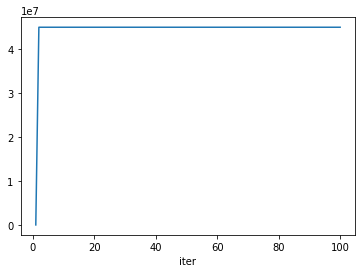

In [8]:
logger.to_dataframe().mean_eval.plot()

#### Get Network with parameters according to trained model

In [9]:
trained_network = problem.parameterize_net(searcher.status['center'])

#### Use Model

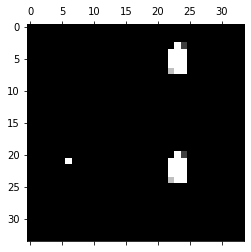

In [81]:
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from IPython.display import display, HTML
import IPython

#TODO
state = generator.generate_moving_state(50, batch_size)

def extract_data(cell, target):
    row1 = np.hstack((cell[0, 0].detach().cpu().numpy(), target[0]))
    row2 = np.hstack((state.food[0], state.y[0]))
    return np.vstack((row1, row2))

@torch.no_grad()
def animate(i):
    global cell
    global target
    global food
    global food_coord
    cell, food, live_count, _ = trained_network(cell, food, 1)
    #print((cell > 1.1).to(torch.float).sum()) # this shows the potential importance of including clamp
    #print('live_count: ', live_count[0].item())
    if i % 2 == 0:
        target = generator.move_towards_food(target, food_coord)
        #print(target.sum(dim=(1,2)))
    mat.set_data(extract_data(cell, target)) 

cell = torch.tensor(state.x, device=device)
food = torch.tensor(state.food, device=device)
target = state.x[:, 0]
food_coord = generator.get_food_coord_from_food(state.food)
fig, ax = plt.subplots()

mat = ax.matshow(extract_data(cell, target), cmap='gray')

video = IPython.display.HTML(animation.FuncAnimation(fig, animate, frames=150, interval=50).to_jshtml())
video

In [91]:
state = generator.generate_moving_state(50, batch_size)
cell = torch.tensor(state.x, device=device)
food = torch.tensor(state.food, device=device)
target = state.x[:, 0]
food_coord = generator.get_food_coord_from_food(state.food)

In [86]:
#animate
def animate2(i, cell, target, food):
    global food_coord
    cell, food, live_count, _ = trained_network(cell, food, 1)
    #print((cell > 1.1).to(torch.float).sum()) # this shows the potential importance of including clamp
    #print('live_count: ', live_count[0].item())
    if i % 2 == 0:
        target = generator.move_towards_food(target, food_coord)
        #print(target.sum(dim=(1,2)))
    mat.set_data(extract_data(cell, target)) 
    i += 1
    return cell, target, i

i = 0

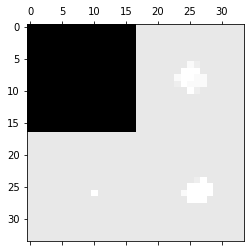

In [95]:
fig, ax = plt.subplots()
mat = ax.matshow(extract_data(cell, target), cmap='gray')
cell, target, i = animate2(i, cell, target, food)